In [ ]:
!pip install pytorch-lightning
  

     |████████████████████████████████| 582 kB 5.2 MB/s 
     |████████████████████████████████| 136 kB 46.3 MB/s 
     |████████████████████████████████| 596 kB 44.3 MB/s 
     |████████████████████████████████| 408 kB 44.8 MB/s 
     |████████████████████████████████| 1.1 MB 40.6 MB/s 
     |████████████████████████████████| 144 kB 50.8 MB/s 
     |████████████████████████████████| 94 kB 1.7 MB/s 
     |████████████████████████████████| 271 kB 51.1 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torchvision.models as models
import torchvision.datasets as td
import torch.nn as nn
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from torchvision.transforms import transforms
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
resnet18 = models.resnet18
model = resnet18(num_classes = 10)
print(model.conv1)

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [ ]:
transform = transforms.ToTensor()
train_ds = td.MNIST("mnist",train = True,download=True,transform=transform)
test_ds = td.MNIST("mnist",train = False,download=True,transform=transform)


train_dl = DataLoader(train_ds, batch_size=64,shuffle= True)
test_dl = DataLoader(test_ds, batch_size=64)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [ ]:
import torch
class RestNetMNIST(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.model = resnet18(num_classes = 10)
    self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    self.loss = nn.CrossEntropyLoss()
  
  def forward(self,x):
    return self.model(x)

  def training_step(self,train_batch,batch_idx):
    x,y = train_batch
    logits = self(x)
    loss = self.loss(logits,y)
    return loss
  
  def configure_optimizers(self):
    return torch.optim.RMSprop(self.parameters(),lr=0.005)


# New Section

In [ ]:
model = RestNetMNIST()
trainer = pl.Trainer(gpus= 1,max_epochs=1,progress_bar_refresh_rate=20)
trainer.fit(model,train_dl)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 11.2 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
11.

Training: 0it [00:00, ?it/s]

In [ ]:
def get_prediction(x,model):
  model.freeze()
  probabilities = torch.softmax(model(x),dim = 1) 
  predicted_class = torch.argmax(probabilities,dim = 1)
  return predicted_class, probabilities

In [ ]:
true_y, pred_y = [],[]

for batch in tqdm(iter(test_dl),total=len(test_dl)):
  x,y = batch
  true_y.extend(y)
  preds,probs = get_prediction(x,model)
  pred_y.extend(preds.cpu())

  0%|          | 0/157 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_y,pred_y,digits = 3))

              precision    recall  f1-score   support

           0      0.979     0.996     0.987       980
           1      0.996     0.984     0.990      1135
           2      0.988     0.970     0.979      1032
           3      0.965     0.992     0.979      1010
           4      0.988     0.965     0.976       982
           5      0.989     0.978     0.983       892
           6      0.998     0.978     0.988       958
           7      0.989     0.975     0.982      1028
           8      0.913     0.991     0.950       974
           9      0.975     0.946     0.961      1009

    accuracy                          0.978     10000
   macro avg      0.978     0.978     0.977     10000
weighted avg      0.978     0.978     0.978     10000



In [ ]:
vars(test_ds)

{'data': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         ...,
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
    

Actual Value: 9.0
Predicted Value: 8.0


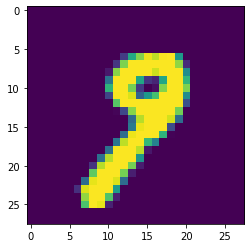

In [ ]:
type(test_ds.data)
test_ds.data[0]
#img = plt.imshow(test_ds.data[0])
# print(float(test_ds.targets[1]))
# print(float(pred_y[1]))

# for i in range()


for i in range(len(test_ds.targets)):
  if  float(test_ds.targets[i]) != float(pred_y[i]):
    print("Actual Value: {}".format(float(test_ds.targets[i])))
    print("Predicted Value: {}".format(float(pred_y[i])))
    plt.imshow(test_ds.data[i])
    break

model.training_step()
# Write a for loop to show where the prediction and test_ds has different values and then show the image

In [ ]:
!pip install pytorch-lightning
  

     |████████████████████████████████| 582 kB 5.2 MB/s 
     |████████████████████████████████| 408 kB 42.8 MB/s 
     |████████████████████████████████| 596 kB 44.5 MB/s 
     |████████████████████████████████| 136 kB 28.6 MB/s 
     |████████████████████████████████| 1.1 MB 35.8 MB/s 
     |████████████████████████████████| 144 kB 44.3 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
     |████████████████████████████████| 271 kB 52.2 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np
a = 10**np.arange(-2,2.1,0.1)

100.00000000000082